In [1]:
setwd('../../')
source('.Rprofile')
setwd('./benchmark/analysis')

library(ggplot2)
library(tidyverse)
library(ggpubr)
library(reshape2)
library(patchwork)
library(pheatmap)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.0      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
data <- read_csv('../results/benchmark.csv')
data$cells <- as.numeric(data$cells)
data <- data[data$global_score > 0,]
data <- data[data$cells == 0,] %>% filter(!method %in% c('SLAT', 'SLAT_harmony', 'PCA')) %>% 
        mutate(method = replace(method, method == 'SLAT_dpca', 'SLAT'))
data[nrow(data) + 1,] <- list("stereo_mouse_embryo",0,0,'PASTE',NA,NA,NA,NA,NA,NA) # PASTE can not run on Stereo-seq

data <- data %>% 
  mutate(across('dataset', str_replace, 'merfish_mouse_hypothalamic', 'MERFISH')) %>%
  mutate(across('dataset', str_replace, 'visium_human_DLPFC', 'Visium')) %>%
  mutate(across('dataset', str_replace, 'stereo_mouse_embryo', 'Stereo-seq'))
data$dataset <- factor(data$dataset, levels = c('Visium','MERFISH','Stereo-seq'))
data$method <- factor(data$method, levels = c('SLAT','PASTE','STAGATE','Harmony','Seurat'))
data %>% tail()

Rows: 936 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): dataset, method
dbl (8): cells, seed, celltype_score, edge_score, euclidean_dis, global_scor...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


dataset,cells,seed,method,celltype_score,edge_score,euclidean_dis,global_score,region_score,run_time
<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Visium,0,7,Harmony,0.8965227,-42.64722,0.17537200,0.6132922,0.6550757,9.992527
Visium,0,7,PASTE,0.7431296,-22.83455,0.04024688,0.6410544,0.8292204,43.722354
Visium,0,7,SLAT,0.8283791,-34.21088,0.02549772,0.6878856,0.8143578,16.350999
Visium,0,7,STAGATE,0.7602356,-83.67246,0.12710486,0.5844083,0.7428491,24.356482
Visium,0,7,Seurat,0.8623107,-45.73528,0.17404606,0.6096467,0.6710600,120.943000
Stereo-seq,0,0,PASTE,NA,NA,NA,NA,NA,NA


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


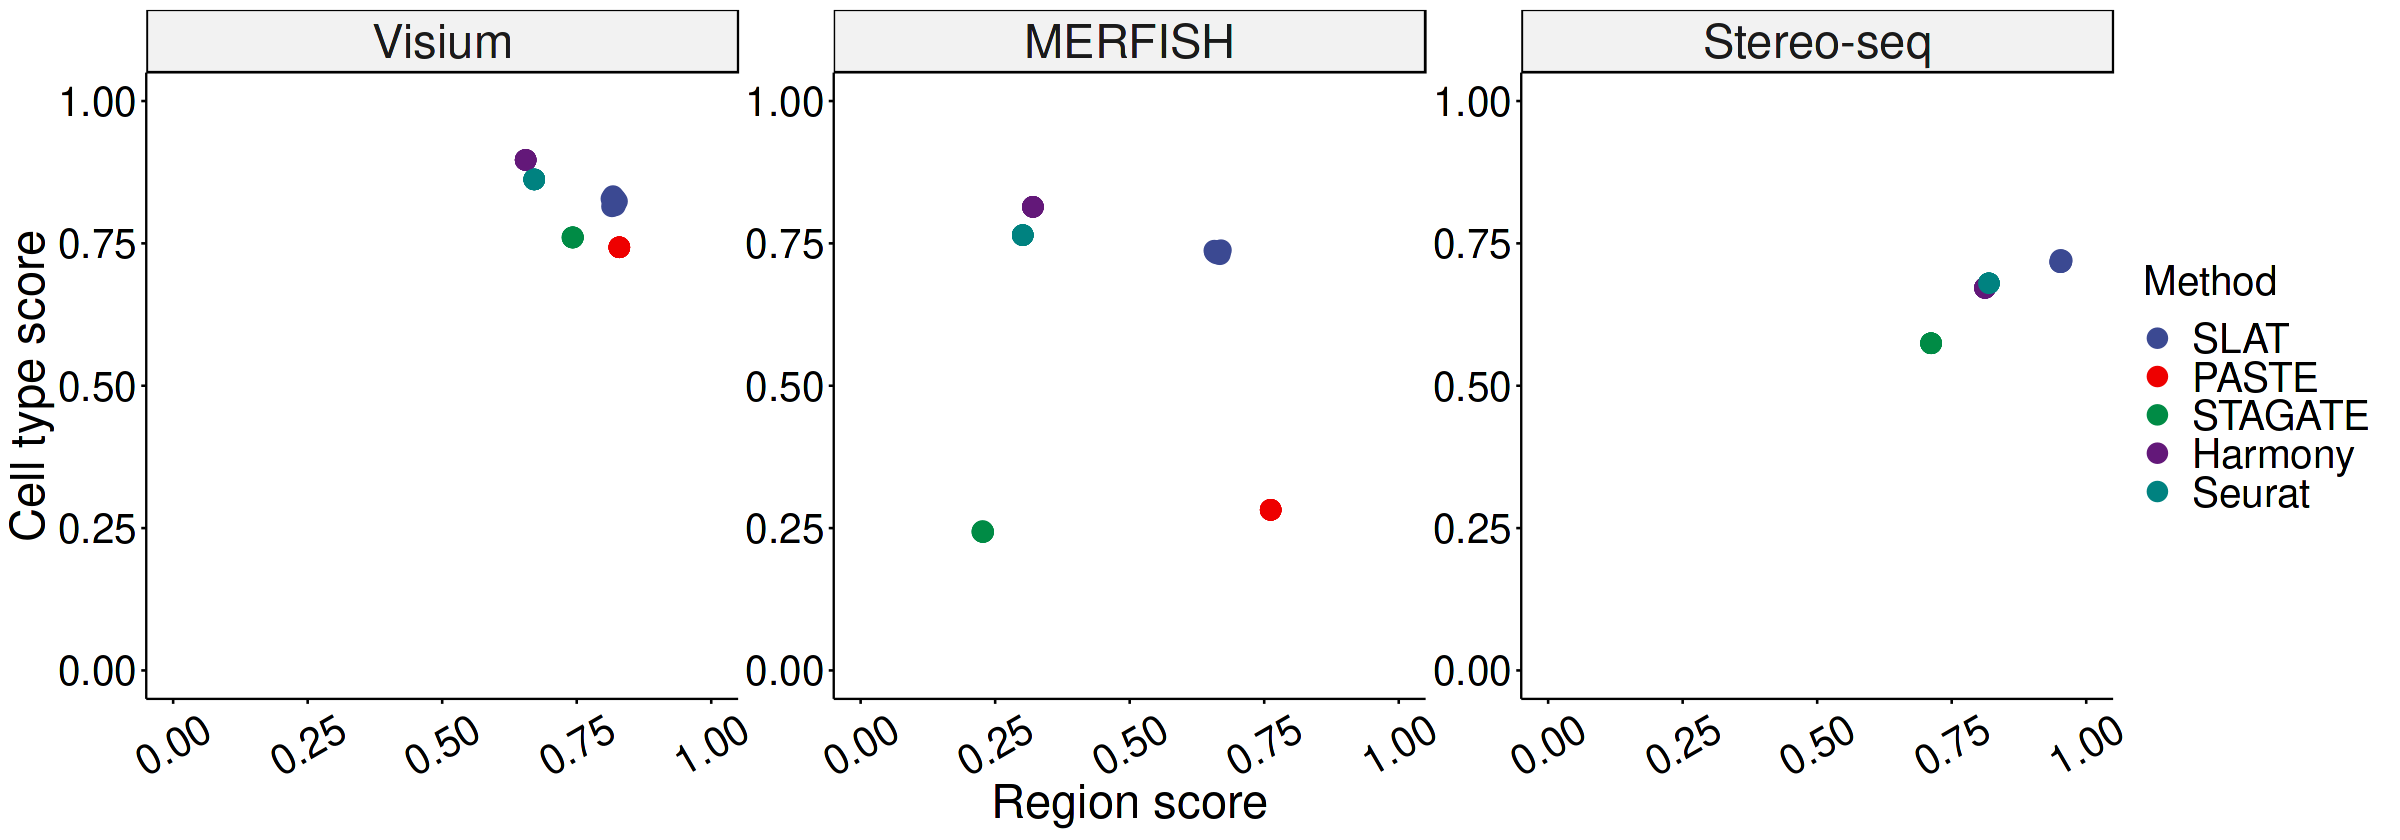

In [3]:
options(repr.plot.width=20, repr.plot.height=7)
ggscatter(data, x="region_score", y="celltype_score", color='method', size=5,
        palette='aaas', xlab='Region score', ylab='Cell type score', lab.size=30,
        legend.title = 'Method') %>% 
ggpar(xlim=c(0,1), ylim=c(0,1), legend='right', font.legend=24, font.subtitle=24,
    font.xtickslab=24, font.ytickslab=24, font.x=28, font.y=28) +
facet_wrap(~dataset, scales="free") +
theme(axis.text.x=element_text(angle=30, vjust=0.5, hjust=0.5), strip.text.x=element_text(size=28))


# confuse matrix

[1] "STAGATE"
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.8198261           0.8241026         0.6908651
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.8292204           0.7431296         0.6410544
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.7425687           0.7604459         0.5843732
[1] "STAGATE"
[1] "MERFISH"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.6628782           0.7346577         0.4899797
[1] "MERFISH"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.7620087           0.2819713         0.2231753
[1] "MERFISH"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.2270352           0.2435667        0.06809498
[1] "STAGATE"
[1] "Stereo-seq"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.9528118           0.7183684         0.6979921
[1] "S

Warning message:
“Removed 4 rows containing missing values (`geom_text()`).”


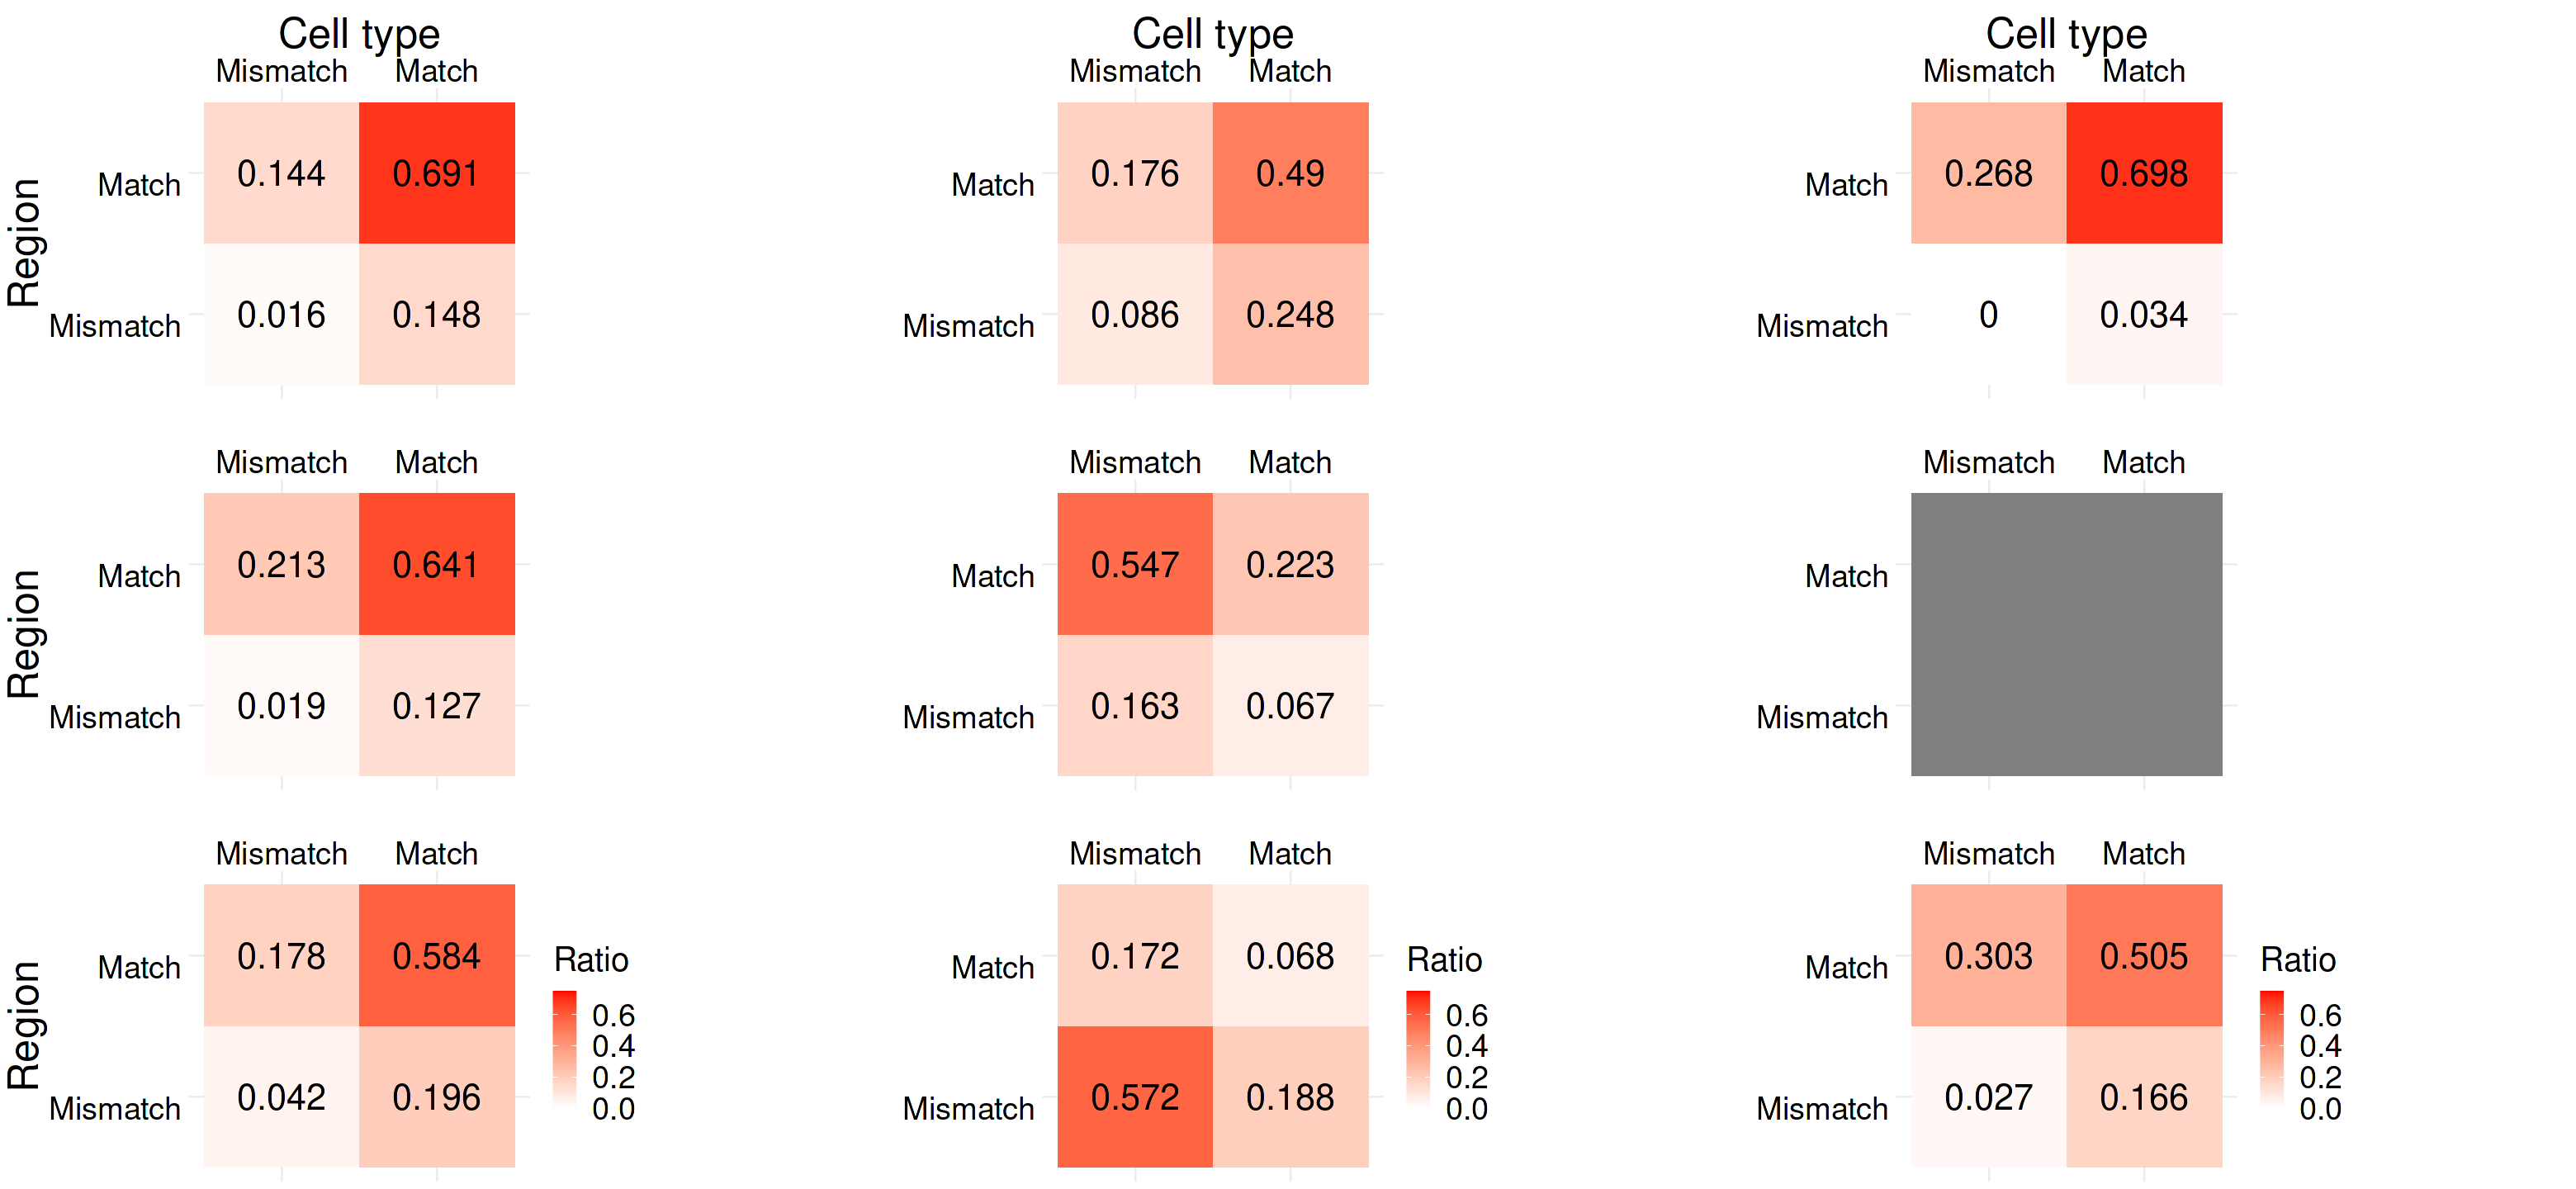

In [8]:
options(repr.plot.width=4, repr.plot.height=3)
p2_list <- list()
j <- 1 # column for methods
for(datasets in c('Visium','MERFISH','Stereo-seq')){
    i <- 1 # row for dataset
    p_list <- list()
    print(methods)
    for(methods in c('SLAT','PASTE','STAGATE')){
        print(datasets)
        data_method <- data %>% filter(method == methods, dataset == datasets)  %>% 
            summarise(mean_region_score = mean(region_score), mean_celltype_score = mean(celltype_score), mean_global_score = mean(global_score)) %>% 
            as.matrix()
        print(data_method)
        confusion_matrix <- matrix(0, nrow = 2, ncol = 2)
        confusion_matrix[2,2] <- data_method[1,3]
        confusion_matrix[1,2] <- data_method[1,1] * (1 - data_method[1,2])
        confusion_matrix[2,1] <- data_method[1,2] * (1 - data_method[1,1])
        confusion_matrix[1,1] <- 1 - confusion_matrix[1,2] - confusion_matrix[2,2] - confusion_matrix[2,1]
        rownames(confusion_matrix) <- c('Mismatch', 'Match')
        colnames(confusion_matrix) <- c('Mismatch', 'Match')
        confusion_matrix <- confusion_matrix %>% melt()
        colnames(confusion_matrix) <- c('Cell_type', 'Region', 'Ratio')
        # print(confusion_matrix)

        p <- ggplot(confusion_matrix, aes(x = Cell_type, y = Region, fill = Ratio)) + 
            geom_tile() + 
            geom_text(aes(x = Cell_type, y = Region, label = round(Ratio, digits = 3)), color = "black", size = 9) + 
            scale_fill_gradient2(low = "white", high = "red", limit = c(-0.01, 0.7)) +
            labs(x = 'Cell type', y = 'Region') + 
            scale_x_discrete(position = "top") + 
            theme_minimal() +
            theme(  text = element_text(size = 28),
                    axis.text = element_text(vjust = 1, hjust = 0.5, color = "black"),
                    axis.title = element_text(size = 30),
                    plot.title = element_text(size = 30, hjust = 0.5),
                    legend.title = element_text(size = 24),
                    axis.ticks = element_blank(),
                    plot.margin = unit(c(0,160,0,0), "pt")
                )

        if (i != 3) {p <- p + theme(legend.position = "none") }
        if (i > 1) {p <- p + labs(x='') }
        if (j > 1) {p <- p + labs(y='') }
        # if (i > 1) {p <- p + theme(plot.title = element_blank())}
        # print(p)
        p_list[[i]] <- p
        i <- i + 1
        }
    p2 <-  do.call(patchwork::wrap_plots, c(p_list, ncol = 1))
    p2_list[[j]] <- p2
    j <- j + 1
}

options(repr.plot.width = 26, repr.plot.height = 12)
do.call(patchwork::wrap_plots, c(p2_list, ncol = 3))

[1] "STAGATE"
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.8198261           0.8241026         0.6908651
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.6550757           0.8965227         0.6132922
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]           0.67106           0.8623107         0.6096467
[1] "Seurat"
[1] "MERFISH"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.6628782           0.7346577         0.4899797
[1] "MERFISH"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.3201809           0.8140986         0.2701185
[1] "MERFISH"
     mean_region_score mean_celltype_score mean_global_score
[1,]           0.30131           0.7645041         0.2375234
[1] "Seurat"
[1] "Stereo-seq"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.9528118           0.7183684         0.6979921
[1] "Ste

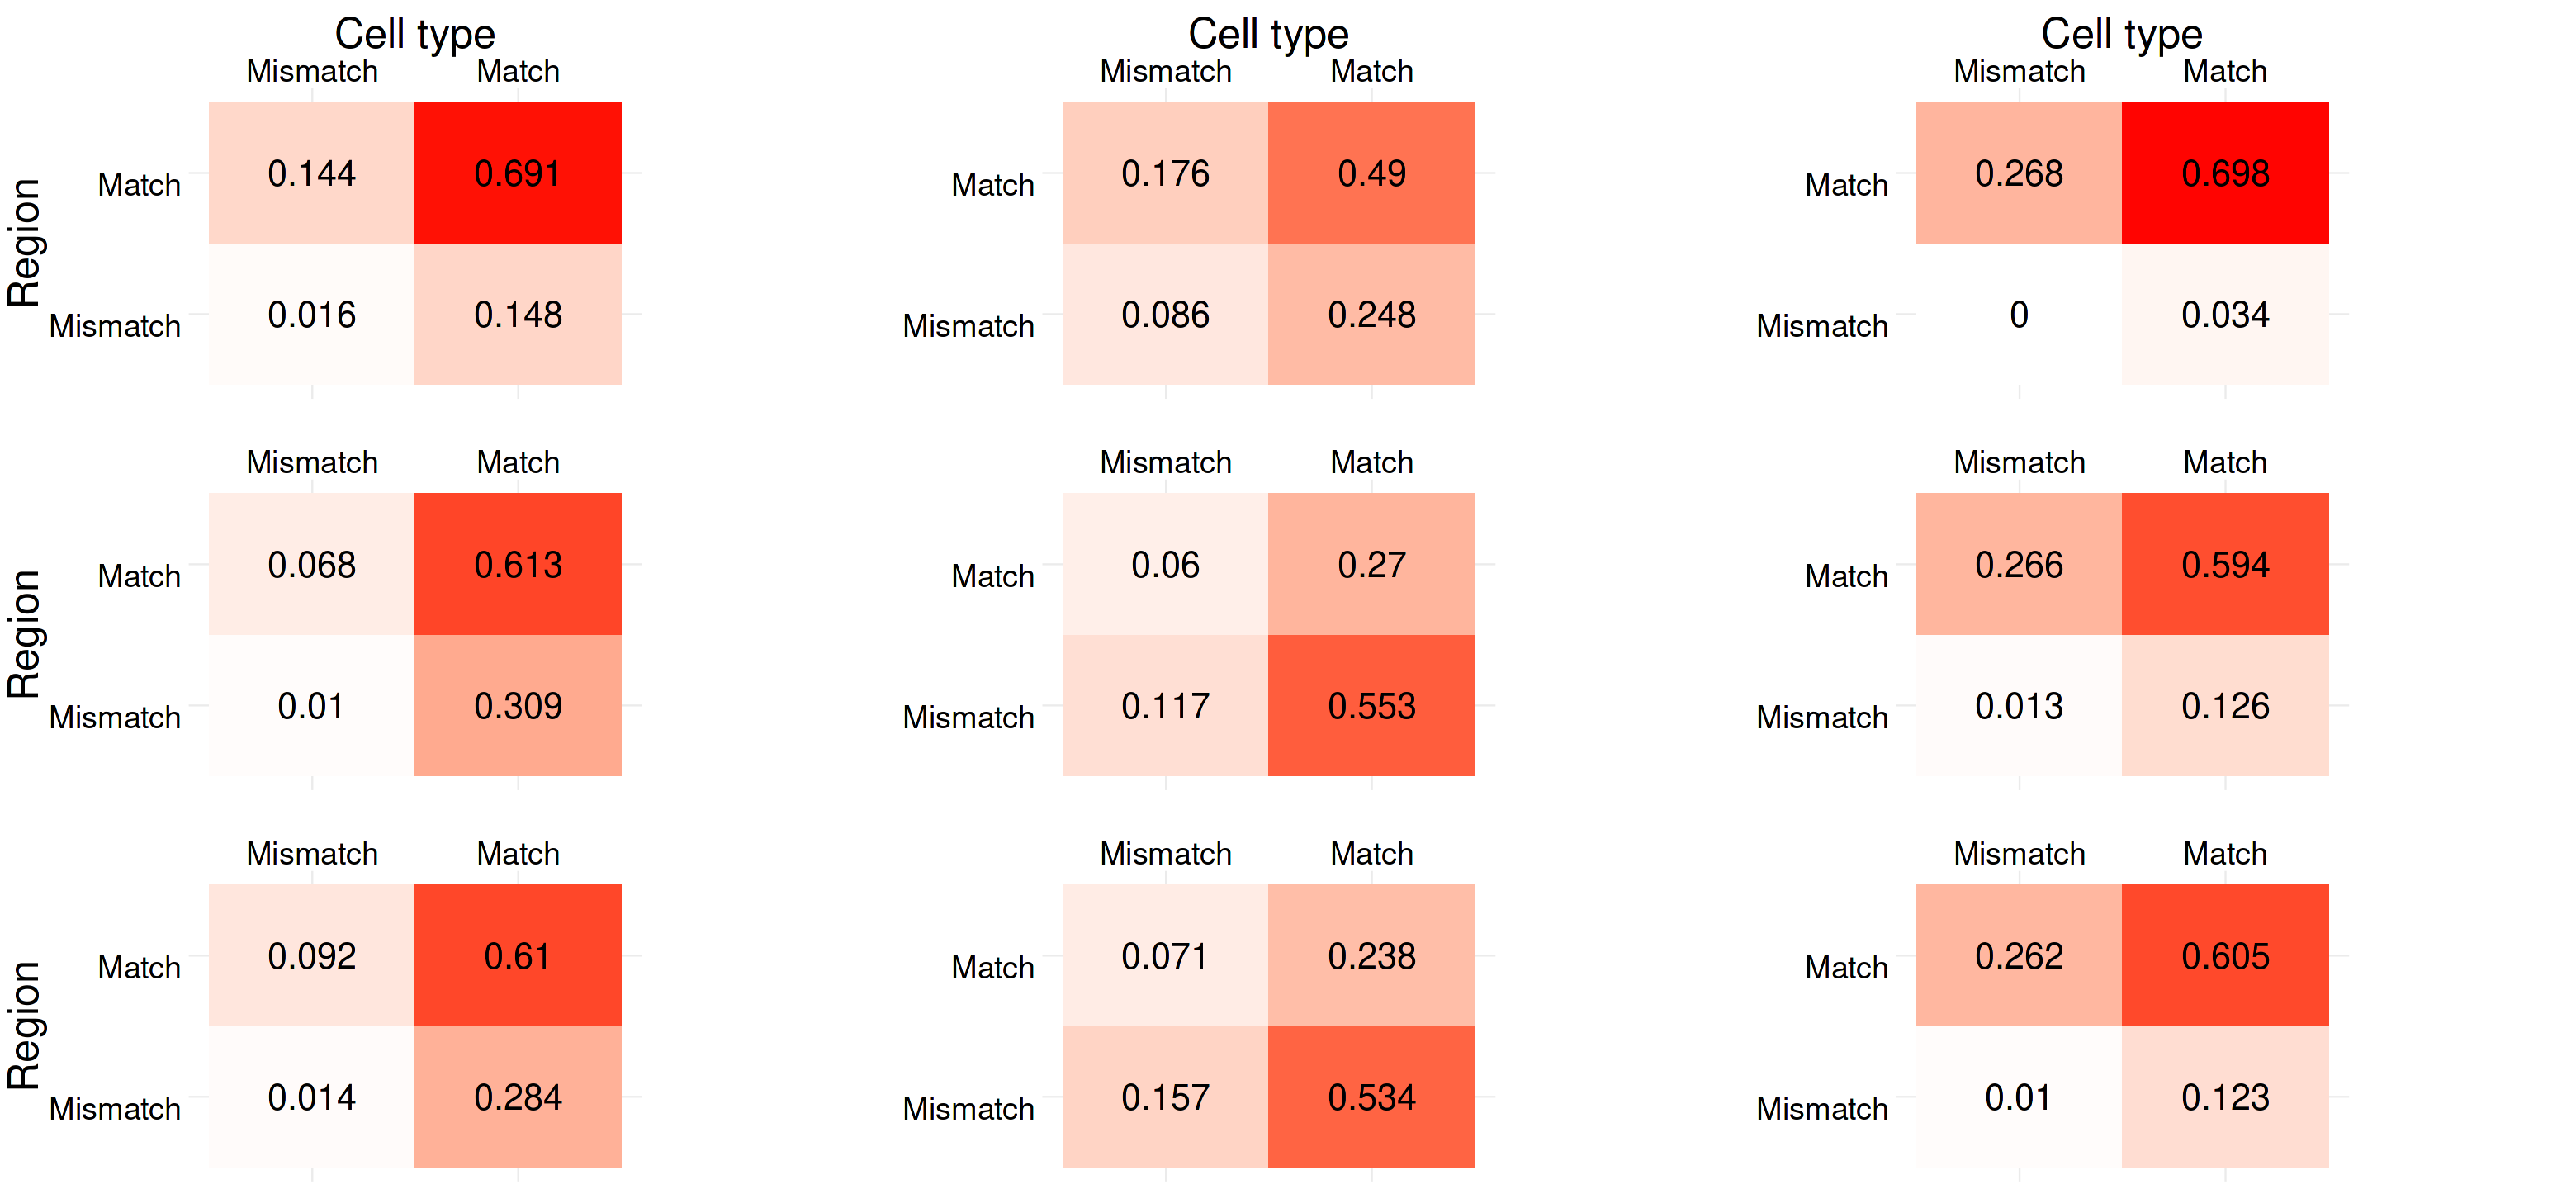

In [5]:
options(repr.plot.width=4, repr.plot.height=3)
p2_list <- list()
j <- 1 # column for methods
for(datasets in c('Visium','MERFISH','Stereo-seq')){
    i <- 1 # row for dataset
    p_list <- list()
    print(methods)
    for(methods in c('SLAT','Harmony','Seurat')){
        print(datasets)
        data_method <- data %>% filter(method == methods, dataset == datasets)  %>% 
            summarise(mean_region_score = mean(region_score), mean_celltype_score = mean(celltype_score), mean_global_score = mean(global_score)) %>% 
            as.matrix()
        print(data_method)
        confusion_matrix <- matrix(0, nrow = 2, ncol = 2)
        confusion_matrix[2,2] <- data_method[1,3]
        confusion_matrix[1,2] <- data_method[1,1] * (1 - data_method[1,2])
        confusion_matrix[2,1] <- data_method[1,2] * (1 - data_method[1,1])
        confusion_matrix[1,1] <- 1 - confusion_matrix[1,2] - confusion_matrix[2,2] - confusion_matrix[2,1]
        rownames(confusion_matrix) <- c('Mismatch', 'Match')
        colnames(confusion_matrix) <- c('Mismatch', 'Match')
        confusion_matrix <- confusion_matrix %>% melt()
        colnames(confusion_matrix) <- c('Cell_type', 'Region', 'Ratio')
        # print(confusion_matrix)

        p <- ggplot(confusion_matrix, aes(x = Cell_type, y = Region, fill = Ratio)) + 
            geom_tile() + 
            geom_text(aes(x = Cell_type, y = Region, label = round(Ratio, digits = 3)), color = "black", size = 9) + 
            scale_fill_gradient2(low = "white", high = "red", limit = c(-0.01, 0.7)) +
            labs(x = 'Cell type', y = 'Region') + 
            scale_x_discrete(position = "top") + 
            theme_minimal() +
            theme(  text = element_text(size = 28),
                    axis.text = element_text(vjust = 1, hjust = 0.5, color = "black"),
                    axis.title = element_text(size = 30),
                    plot.title = element_text(size = 30, hjust = 0.5),
                    legend.title = element_text(size = 24),
                    axis.ticks = element_blank(),
                    plot.margin = unit(c(0,160,0,0), "pt")
                )

        if (TRUE) {p <- p + theme(legend.position = "none") }
        if (i > 1) {p <- p + labs(x='') }
        if (j > 1) {p <- p + labs(y='') }
        # if (i > 1) {p <- p + theme(plot.title = element_blank())}
        # print(p)
        p_list[[i]] <- p
        i <- i + 1
        }
    p2 <-  do.call(patchwork::wrap_plots, c(p_list, ncol = 1))
    p2_list[[j]] <- p2
    j <- j + 1
}

options(repr.plot.width = 26, repr.plot.height = 12)
do.call(patchwork::wrap_plots, c(p2_list, ncol = 3))